<h2 align="center">Линейная регрессия</h2>


В общем виде уравнение линейной регрессии выглядит следующим образом:

**Простая линейная регрессия**: <h5 align=center>$$Y = \beta_0 + \beta_1 X + \epsilon$$</h5>

**Множественная линейная регрессия**: <h5 align=center>$$Y = \beta_0 + \beta_1 X_1 + \beta_2 X_2 +...+ \beta_p X_p + \epsilon$$ </h5>

Соответственно наша задача определить коэффициенты, наилучшим образом описывающие наши данные.<br>
Далее я не буду приводить сложных формул, поскольку хочу сосредоточить внимание преподавателя **на своём понимании сути происходящих процессов**, а не на том как хорошо я умею копи-пастить или как хорошо я знаю LaTex.

Для начала импортируем данные и проведем предварительный анализ. Данные описывают затраты на рекламу по телевизору, на радио и в газетах и количество продаж по двумста магазинам.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from scipy.stats import skew
from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from yellowbrick.regressor import PredictionError, ResidualsPlot
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
import pickle
from sklearn.metrics import mean_squared_error

%matplotlib inline

import matplotlib.pyplot as plt
plt.style.use("ggplot")
plt.rcParams['figure.figsize'] = (12, 8)


### **Импорт данных**


In [2]:
dataset = pd.read_csv('Advertising.csv')
dataset.head()

,Unnamed: 0,TV,radio,newspaper,sales
0,1,230.1,37.8,69.2,22.1
1,2,44.5,39.3,45.1,10.4
2,3,17.2,45.9,69.3,9.3
3,4,151.5,41.3,58.5,18.5
4,5,180.8,10.8,58.4,12.9


In [3]:
print(dataset.columns)
print(dataset.shape)

Index(['Unnamed: 0', 'TV', 'radio', 'newspaper', 'sales'], dtype='object')
(200, 5)


Как видно, колонка с индексами не имеет отношения к данным, уберем её.

In [4]:
dataset.drop(['Unnamed: 0'], axis = 1, inplace = True)
print(dataset.shape)

(200, 4)


*Важно помнить о сохранности исходных данных* (inplace = True). <br>
### **Проверка данных на NaN**
Но, прежде чем приступить к анализу входных данных, нужно их проверить на отсутствующие значения.

In [5]:
dataset.isna().sum()

TV           0
radio        0
newspaper    0
sales        0
dtype: int64

Все значения на месте. Но что делать, если некоторые отсутствуют? Мы можем выбрать из двух вариантов: исключать недостающие значения или использовать значения последовательности для генерации недостающих.
Рассмотрим оба варианта.

**Удаление недостающих значений.**

pandas.DataFrame.dropna()

Здесь мы можем пойти несколькими путями.<br>
Удалять столбец, то есть исключать предиктор из исследования целиком:


In [6]:
dataset.dropna(axis=1, inplace=True)

Удалять строку. Тут важно помнить, что мы удаляем значения с соответствующим индексом из *всех* столбцов, то есть вносим изменения в весь набор данных:

In [7]:
dataset.dropna(axis=0, inplace=True)

Но мы можем явно указать колонку для обработки:

In [8]:
dataset.dropna(subset=['TV'],axis=0,inplace=True)

И в заключение, мы можем удалять колонку при условии некоторого процента отсутствующих значений:

In [9]:
dataset.dropna(thresh=0.8*len(dataset),axis=1,inplace=True)
print(dataset.shape)

(200, 4)


Как мы видим ничего удалено небыло.

**Генерация недостающих значений.** <br>
Тут мы можем подставлять значение некоторой функции от остальной последовательности (среднее значение, например) или просто заданное значение. Это для числовых данных.<br>Для категориальных мы можем подставить самое часто встречающееся, например.

In [10]:
numeric = dataset.select_dtypes(include=np.number)
numeric_columns = numeric.columns
dataset[numeric_columns] = dataset[numeric_columns].fillna(dataset.mean())
print(numeric_columns)

Index(['TV', 'radio', 'newspaper', 'sales'], dtype='object')


### **Удаление дубликатов.**

Название раздела отражает его суть. Зачем нам обрабатывать одни и те-же данные?

In [11]:
print(dataset.duplicated().sum())
dataset.drop_duplicates(inplace=True)

0


### **Визуальный анализ входных данных.**

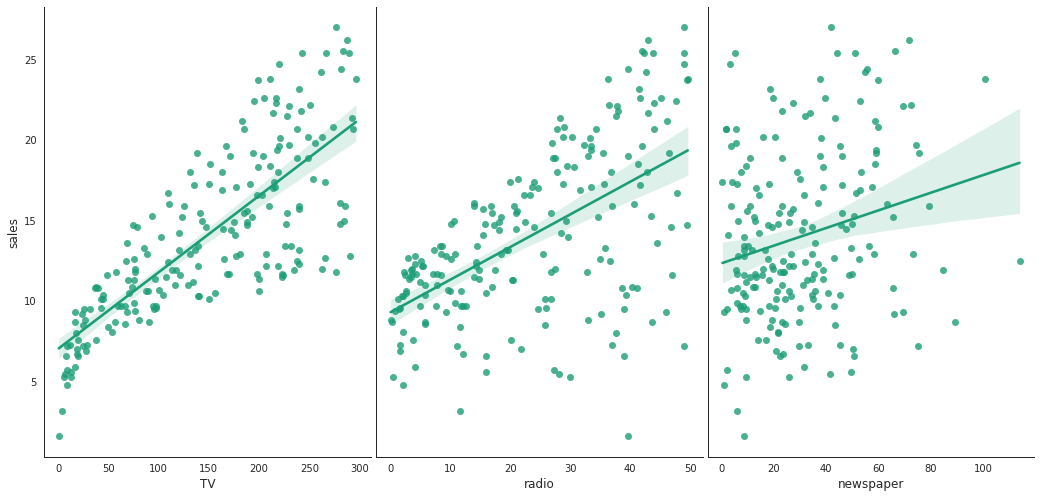

In [12]:
sns.set_style(style='white')
sns.set_palette(sns.color_palette("Dark2"))
sns.pairplot(dataset, x_vars=['TV', 'radio', 'newspaper'], y_vars='sales', height=7, aspect=0.7, kind='reg')

И тут начинается интересное. А что, собственно, мы тут видим? <br>
А види мы тут, как минимум, что доверительный интервал для newspaper слишком большой. Что это значит? То, что newspaper имеет малую корреляцию с выходом и мало на него влияет. <br>
Но было бы очень неплохо увидеть это в цифрах.

<AxesSubplot:>

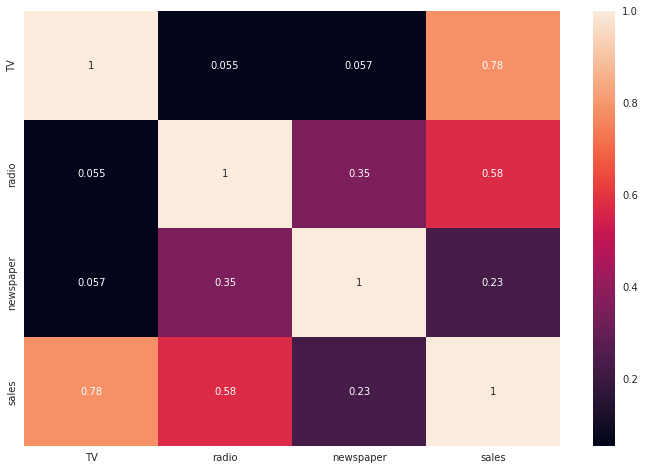

In [13]:
sns.heatmap(dataset.corr(), annot=True)

Моё понимание происходящего. <br>

1. Корреляция (связь двух величин, то есть влияние одной на другую) с выходом самая высокая у TV. Это самый значимый предиктор.
2. В мультиколлениарность мы тут не влетим, наши предикторы описывают выход, а не друг друга.
3. Нужно подумать о выкинуть newspaper.


### **Нормализация входных данных.**

Суть нормализации в как-бы обезразмеривании данных. Если в нашей модели присутствовали, например, расстояние до звезды и её видимый размер. То количественная разница значений была-бы огромна. Что могло бы привести к неправильному обучению. Нормализация позволяет нам сбалансировать предикторы, перемасштабировать их, не теряя семантики. <br>
Есть много вариантов, но мне больше всего понравилась нормализация средним или Z-оценка. Поскольку она хорошо (на мой взгляд) работает с выбросами.

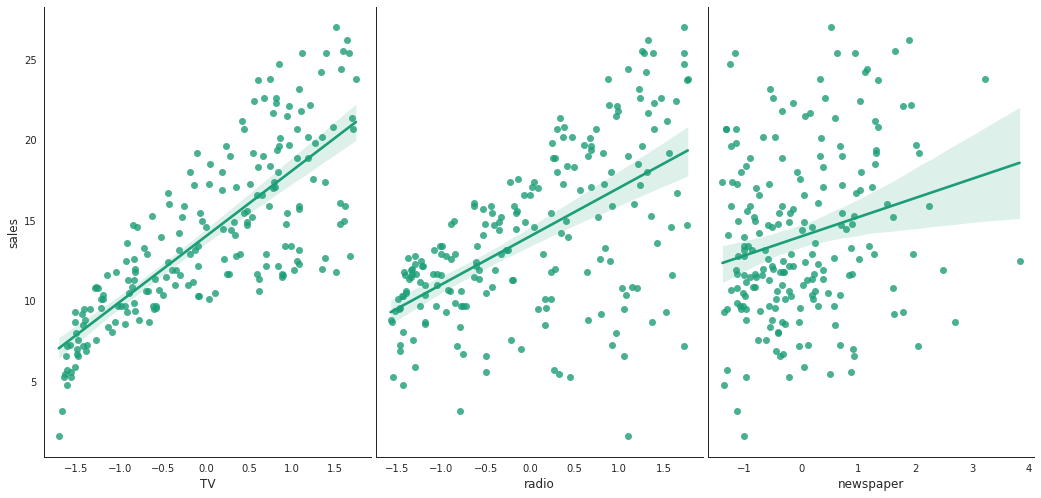

In [14]:
for key in dataset:
    if key != 'sales':
        dataset[key] = (dataset[key]-dataset[key].mean())/dataset[key].std() 
sns.pairplot(dataset, x_vars=['TV', 'radio', 'newspaper'], y_vars='sales', height=7, aspect=0.7, kind='reg')

<AxesSubplot:>

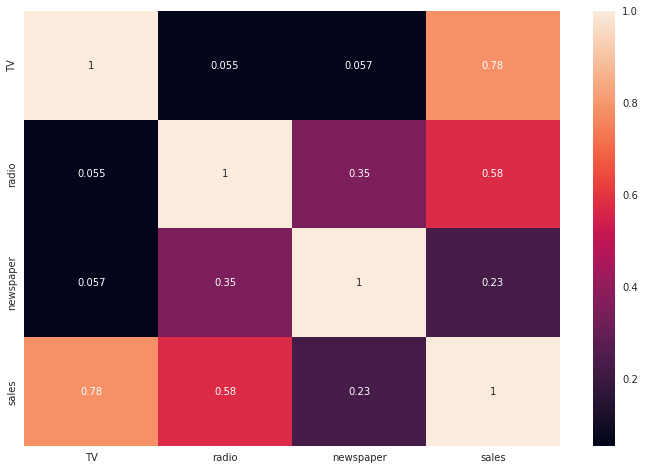

In [15]:
sns.heatmap(dataset.corr(), annot=True)

Из графиков водно, что нормализация никак не повлияла на семантику, но при это мы имеем гораздо более близкие диапазоны предикторов.

In [16]:
dataset.head()

,TV,radio,newspaper,sales
0,0.967425,0.979066,1.774493,22.1
1,-1.194379,1.080097,0.667903,10.4
2,-1.512360,1.524637,1.779084,9.3
3,0.051919,1.214806,1.283185,18.5
4,0.393196,-0.839507,1.278593,12.9


### **Отбор признаков**

$R^2$ метрика. Или коэффициент детерминации. Очень важная штука. Показывает количественно, насколько точно наша модель описывает предсказываемую переменную.

Итак, исследуем влияние каждого из предикторов на выходную переменную.

In [17]:
X = dataset[['TV', 'radio', 'newspaper']]
y = dataset.sales

model = LinearRegression().fit(X[['TV', 'radio', 'newspaper']], y)
prediction = model.predict(X[['TV', 'radio', 'newspaper']])

print("For model with TV, radio, newspaper predictors R2 score is: {:.5f}\nCoefficients are: {}".format(r2_score(y, prediction), model.coef_))

model = LinearRegression().fit(X[['TV', 'radio']], y)
prediction = model.predict(X[['TV', 'radio']])

print("\nFor model with TV, radio predictors R2 score is: {:.5f}\nCoefficients are: {}".format(r2_score(y, prediction), model.coef_))

model = LinearRegression().fit(X[['TV', 'newspaper']], y)
prediction = model.predict(X[['TV', 'newspaper']])

print("\nFor model with TV, newspaper predictors R2 score is: {:.5f}\nCoefficients are: {}".format(r2_score(y, prediction), model.coef_))

model = LinearRegression().fit(X[['radio', 'newspaper']], y)
prediction = model.predict(X[['radio', 'newspaper']])

print("\nFor model with radio, newspaper predictors R2 score is: {:.5f}\nCoefficients are: {}".format(r2_score(y, prediction), model.coef_))

For model with TV, radio, newspaper predictors R2 score is: 0.89721
Coefficients are: [ 3.92908869  2.79906919 -0.02259517]

For model with TV, radio predictors R2 score is: 0.89719
Coefficients are: [3.92824471 2.79111441]

For model with TV, newspaper predictors R2 score is: 0.64584
Coefficients are: [4.0266679  0.96303807]

For model with radio, newspaper predictors R2 score is: 0.33271
Coefficients are: [2.9551771  0.14470096]


Цифры жестоки и беспощадны - прощай, newspaper! <br>
Но пока я не буду выкидывать newspaper, поскольку хочу посмотреть что от него останется в Lasso regression.

### **Обучение модели.**

Итак, что мы тут можем предпринять. Мне известны четыре основных метода нахождения весов для линейной регрессии:
1. Метод наименьших квадратов (Least Squares). Классика. Имеет запись вида:<br> 
$\sum_{i=1}^M (y_i - \hat{y_i})^2 = \sum_{i=1}^M (y_i - \sum_{j=1}^p(\beta_j \times x_{ij}))$.
2. Ridge (гребневая) регрессия. Отличается от МНК тем, что к весам добавляется штраф: <br> 
$\sum_{i=1}^M (y_i - \hat{y_i})^2 = \sum_{i=1}^M (y_i - \sum_{j=1}^p(\beta_j \times x_{ij})) + \lambda \times \sum_{j=1}^p\beta_j^2$   
3. Lasso (Least Absolute Shrinkage and Selection Operator) регрессия. Тоже добавляется штраф, но другого вида: <br> 
$\sum_{i=1}^M (y_i - \hat{y_i})^2 = \sum_{i=1}^M (y_i - \sum_{j=1}^p(\beta_j \times x_{ij})) + \lambda \times \sum_{j=1}^p|\beta_j|$  
4. ElasticNet - комбинация Lasso и Ridge регрессий.

Всё это красиво, но какова суть и зачем нам оно всё нужно?<br>
Хорошо, когда наш набор данных имеет достаточный размер, не имеет шума и ошибок (ручная оцифровка бумажных данных, например), не имеет мультиколлениарности. Но что делать если всё это имеет место быть? Когда количество наблюдений меньше количества $\beta$? <br>
Мы получим переобучение (overfitting). То есть наша модель опишет обучающую выборку, а не закономерность.<br>
Вот тут на сцену и выходят Ridge и Lasso. Их принципиальная суть в том, что они заставляют модель как-бы недообучится на входном наборе. То есть даже на двух точка эти модели не проведут линию через них, а оставят некоторую ошибку. Я не нашел алгоритма кроме перебоа для нахождения $\lambda$. <br>
Важно помнить, что при большом (в случае Ridge) или очень малом (в случае Lasso) прямая принимает горизонтальный вид. <br>
Принципиальное отличие Ridge и Lasso - Lasso может придать некоторым параметрам нулевое значение, то есть исключить некоторые данные из исследования. В то время как Ridge приведет незначимые параметры к близкому к нулю, но не нулевому значению.<br>
Для оценки модели я буду использовать $R^2$ и RMSE (Root Mean Squared Error).
<br>
<br>
Ну что же, приступим! 

**Least Squares**

In [18]:
X = dataset[['TV', 'radio', 'newspaper']]
y = dataset.sales

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.95)

linear_r = LinearRegression()
linear_r.fit(X_train, y_train)
linear_r_preds = linear_r.predict(X_test)

print("RMSE :", np.sqrt(mean_squared_error(y_test, linear_r_preds)))
print("R^2: ", r2_score(y_test, linear_r_preds))
print("Coefficients are: ", linear_r.coef_)

RMSE : 2.0990538146439053
R^2:  0.8339627815249241
Coefficients are:  [ 4.85512315  2.762974   -0.31385305]


**Ridge regression**

In [19]:
X = dataset[['TV', 'radio', 'newspaper']]
y = dataset.sales

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.95)

ridge_r = Ridge()
ridge_r.fit(X_train, y_train)
ridge_r_preds = ridge_r.predict(X_test)

print("RMSE :", np.sqrt(mean_squared_error(y_test, ridge_r_preds)))
print("R^2: ", r2_score(y_test, ridge_r_preds))
print("Coefficients are: ", ridge_r.coef_)

RMSE : 1.9164497342448914
R^2:  0.8604125428646444
Coefficients are:  [4.14522271 2.63546249 0.84993796]


**Lasso regression**

In [20]:
X = dataset[['TV', 'radio', 'newspaper']]
y = dataset.sales

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.95)

lasso_r = Lasso()
lasso_r.fit(X_train, y_train)
lasso_r_preds = lasso_r.predict(X_test)
    
print("RMSE :", np.sqrt(mean_squared_error(y_test, lasso_r_preds)))
print("R^2: ", r2_score(y_test, lasso_r_preds))
print("Coefficients are: ", lasso_r.coef_)

RMSE : 2.627591434178196
R^2:  0.7443717276736792
Coefficients are:  [2.15437508 2.16812568 0.        ]


**ElasticNet**

In [21]:
X = dataset[['TV', 'radio', 'newspaper']]
y = dataset.sales

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.95)

elastic_r = ElasticNet(l1_ratio=0.75)
elastic_r.fit(X_train, y_train)
elastic_r_preds = elastic_r.predict(X_test)
    
print("RMSE :", np.sqrt(mean_squared_error(y_test, elastic_r_preds)))
print("R^2: ", r2_score(y_test, elastic_r_preds))
print("Coefficients are: ", elastic_r.coef_)

RMSE : 2.733588619121457
R^2:  0.7222326290572663
Coefficients are:  [2.25715035 1.7578694  0.95660584]


**Промежуточные выводы**<br>
Как видно, я задал 5% на обучающую выборку. Если обучение запускать несколько раз, то мы получаем абсолютно разные результаты. Что не удовлетворительно. Поэтому я решил попробовать перекрестное обучение.<br>
Lasso и ElasticNet действительно присваивают нулевой коэффициент для newspaper. Но опять таки, черезчур случайно.<br>
На данном этапе я могу заключить, что обучение на сверхмалом наборе данных в принципе возможно. Но этот метод подходит тодлько в крайних случаях и носит стахастический (случайный) характер.


**Перекрестное обучение**

In [22]:
X = dataset[['TV', 'radio', 'newspaper']]
y = dataset.sales

k_fold = KFold(n_splits=10, shuffle=True)
k_fold.get_n_splits(X)

max_vals = {
    'linear': [[0], [0, 0, 0]],
    'ridge': [[0], [0, 0, 0]],
    'lasso': [[0], [0, 0, 0]],
    'elastic': [[0], [0, 0, 0]]
}

for train_index, test_index in k_fold.split(X):
    X_train = dataset.iloc[train_index][['TV', 'radio', 'newspaper']]
    X_test = dataset.iloc[test_index][['TV', 'radio', 'newspaper']]
    y_train = dataset.iloc[train_index]['sales']
    y_test = dataset.iloc[test_index]['sales']
    
    model = LinearRegression()
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    
    r2 = r2_score(y_test, preds)
    if r2 > max_vals['linear'][0]:
        max_vals['linear'][0] = r2
        max_vals['linear'][1] = model.coef_
    
    model = Ridge()
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    
    r2 = r2_score(y_test, preds)
    if r2 > max_vals['ridge'][0]:
        max_vals['ridge'][0] = r2
        max_vals['ridge'][1] = model.coef_
    
    model = Lasso()
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    
    r2 = r2_score(y_test, preds)
    if r2 > max_vals['lasso'][0]:
        max_vals['lasso'][0] = r2
        max_vals['lasso'][1] = model.coef_
    
    model = ElasticNet(l1_ratio=0.5)
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    
    r2 = r2_score(y_test, preds)
    if r2 > max_vals['elastic'][0]:
        max_vals['elastic'][0] = r2
        max_vals['elastic'][1] = model.coef_
        
for key in max_vals:
    print("{}\n\tR2: {:.5f}\tCoefficients:\t{}".format(key, max_vals[key][0], max_vals[key][1]))  


linear
	R2: 0.93331	Coefficients:	[ 3.91716928  2.79720224 -0.09029276]
ridge
	R2: 0.93311	Coefficients:	[ 3.89465015  2.77978969 -0.08357901]
lasso
	R2: 0.84958	Coefficients:	[3.07191125 1.86936675 0.        ]
elastic
	R2: 0.78923	Coefficients:	[2.40136144 1.60523341 0.00936956]


**Промежуточные выводы**<br>
1. Результат работы с маленькими данными в целом случаен. Тем не менее удалось добится довольно высокой точности модели.
2. Все регресси явно указали на наименее значимый предиктор. Нужно его убрать.
3. При нормального качества данными классическая линейная регрессия не уступает "улучшеным".

Итак, уберем newspaper.

In [23]:
dataset.drop(['newspaper'], axis = 1, inplace = True)

In [24]:
best_linear = LinearRegression()
best_ridge = Ridge()
best_lasso = Lasso()
best_elastic = ElasticNet()

for train_index, test_index in k_fold.split(X):
    X_train = dataset.iloc[train_index][['TV', 'radio']]
    X_test = dataset.iloc[test_index][['TV', 'radio']]
    y_train = dataset.iloc[train_index]['sales']
    y_test = dataset.iloc[test_index]['sales']
    
    model = None
    preds = None
    
    model = LinearRegression()
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    
    r2 = r2_score(y_test, preds)
    if r2 > max_vals['linear'][0]:
        best_linear = model
        max_vals['linear'][0] = r2
        max_vals['linear'][1] = model.coef_
    
    model = Ridge()
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    
    r2 = r2_score(y_test, preds)
    if r2 > max_vals['ridge'][0]:
        best_ridge = model
        max_vals['ridge'][0] = r2
        max_vals['ridge'][1] = model.coef_
    
    model = Lasso()
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    
    r2 = r2_score(y_test, preds)
    if r2 > max_vals['lasso'][0]:
        best_lasso = model
        max_vals['lasso'][0] = r2
        max_vals['lasso'][1] = model.coef_
    
    model = ElasticNet(l1_ratio=0.5)
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    
    r2 = r2_score(y_test, preds)
    if r2 > max_vals['elastic'][0]:
        best_elastic = model
        max_vals['elastic'][0] = r2
        max_vals['elastic'][1] = model.coef_
        
for key in max_vals:
    print("{}\n\tR2: {:.5f}\tCoefficients:\t{}".format(key, max_vals[key][0], max_vals[key][1]))  

linear
	R2: 0.94089	Coefficients:	[3.92580068 2.69045928]
ridge
	R2: 0.94005	Coefficients:	[3.90375558 2.6758192 ]
lasso
	R2: 0.85948	Coefficients:	[3.01077007 1.80821577]
elastic
	R2: 0.80693	Coefficients:	[2.39573945 1.60782255]


Интересно, точность подросла.

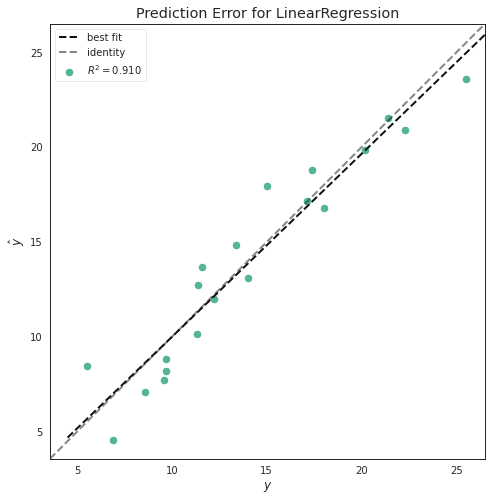

<AxesSubplot:title={'center':'Prediction Error for LinearRegression'}, xlabel='$y$', ylabel='$\\hat{y}$'>

In [25]:
visualizer = PredictionError(best_linear)

visualizer.fit(X_train, y_train)
visualizer.score(X_test, y_test)
visualizer.poof() 

Любопытно. Имеет место довольно большой разброс ошибки. Что бы еще сделать... А проверюка я данные на синергию, благо их всего два осталось.

**Interaction effect**

In [26]:
dataset['interaction'] = dataset['TV'] * dataset['radio']

for train_index, test_index in k_fold.split(X):
    X_train = dataset.iloc[train_index][['TV', 'radio', 'interaction']]
    X_test = dataset.iloc[test_index][['TV', 'radio', 'interaction']]
    y_train = dataset.iloc[train_index]['sales']
    y_test = dataset.iloc[test_index]['sales']
    
    model = None
    preds = None
    
    model = LinearRegression()
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    
    r2 = r2_score(y_test, preds)
    if r2 > max_vals['linear'][0]:
        best_linear = model
        max_vals['linear'][0] = r2
        max_vals['linear'][1] = model.coef_
    
    model = Ridge()
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    
    r2 = r2_score(y_test, preds)
    if r2 > max_vals['ridge'][0]:
        best_ridge = model
        max_vals['ridge'][0] = r2
        max_vals['ridge'][1] = model.coef_
    
    model = Lasso()
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    
    r2 = r2_score(y_test, preds)
    if r2 > max_vals['lasso'][0]:
        best_lasso = model
        max_vals['lasso'][0] = r2
        max_vals['lasso'][1] = model.coef_
    
    model = ElasticNet(l1_ratio=0.5)
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    
    r2 = r2_score(y_test, preds)
    if r2 > max_vals['elastic'][0]:
        best_elastic = model
        max_vals['elastic'][0] = r2
        max_vals['elastic'][1] = model.coef_
        
for key in max_vals:
    print("{}\n\tR2: {:.5f}\tCoefficients:\t{}".format(key, max_vals[key][0], max_vals[key][1]))  

linear
	R2: 0.98737	Coefficients:	[3.82082054 2.78599674 1.39309277]
ridge
	R2: 0.98737	Coefficients:	[3.80060394 2.77055532 1.38598952]
lasso
	R2: 0.89132	Coefficients:	[2.91565064 1.90352609 0.52518498]
elastic
	R2: 0.81358	Coefficients:	[2.33474156 1.55471072 0.73934824]


Ого! Было хорошо, стало совсем здорово!

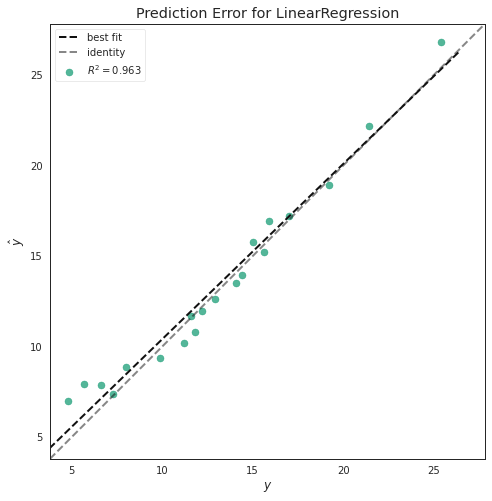

<AxesSubplot:title={'center':'Prediction Error for LinearRegression'}, xlabel='$y$', ylabel='$\\hat{y}$'>

In [27]:
visualizer = PredictionError(best_linear)

visualizer.fit(X_train, y_train)
visualizer.score(X_test, y_test)
visualizer.poof() 

## *Заключение*

Конечно очень интересно. Не буду выносить никаких суждений, так как не имею сколько нибудь значимого опыта. <br>
В этой работе я постарался максимально раскрыть именно своё понимание линейной регрессии и инструментов работы с ней. <br>
Если я в этой работе что-то и копипастил, то исключительно понимая что и куда. <br>
Самое интересное, я начал понимать, что ML это не программирование, не математика - нечто на стыке. Область, в которой навык мышления более значим, чем механические умения.